In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import json
import bz2
import pandas as pd
import matplotlib.pyplot as plt

print(tf.__version__)

2.3.0


In [2]:
from PIL import PngImagePlugin  
LARGE_ENOUGH_NUMBER = 100
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2) # to avoid corrupted .png images

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [4]:
topics = [
  'Culture.Biography.Biography*',
 'Culture.Food and drink',
 'Culture.Internet culture',
 'Culture.Linguistics',
 'Culture.Literature',
 'Culture.Media.Books',
 'Culture.Media.Entertainment',
 'Culture.Media.Films',
 'Culture.Media.Media*',
 'Culture.Media.Music',
 'Culture.Media.Radio',
 'Culture.Media.Software',
 'Culture.Media.Television',
 'Culture.Media.Video games',
 'Culture.Performing arts',
 'Culture.Philosophy and religion',
 'Culture.Sports',
 'Culture.Visual arts.Architecture',
 'Culture.Visual arts.Comics and Anime',
 'Culture.Visual arts.Fashion',
 'Culture.Visual arts.Visual arts*',
 'Geography.Geographical',
 'History and Society.Business and economics',
 'History and Society.Education',
 'History and Society.History',
 'History and Society.Military and warfare',
 'History and Society.Politics and government',
 'History and Society.Society',
 'History and Society.Transportation',
 'STEM.Biology',
 'STEM.Chemistry',
 'STEM.Computing',
 'STEM.Earth and environment',
 'STEM.Engineering',
 'STEM.Libraries & Information',
 'STEM.Mathematics',
 'STEM.Medicine & Health',
 'STEM.Physics',
 'STEM.STEM*',
 'STEM.Space',
 'STEM.Technology']

In [23]:
training_set = pd.read_pickle("/dlabdata1/piccardi/WikipediaImageClassification/training_set.pkl")\
            .sample(300000, random_state=0)
training_set['full_path'] = training_set.image_path.apply(lambda r: '/scratch/WIT_Dataset/images'+r)
training_set[['full_path', 'labels']]

,full_path,labels
736437,/scratch/WIT_Dataset/images/5/54/The_Return_of...,"[Geography.Regions.Europe.Europe*, Geography.R..."
20148,/scratch/WIT_Dataset/images/a/a2/PIA20862-Cere...,"[STEM.Space, STEM.STEM*]"
2770647,/scratch/WIT_Dataset/images/f/fa/Grimsby_-_The...,"[Geography.Regions.Europe.Europe*, Geography.R..."
1930902,/scratch/WIT_Dataset/images/9/93/Gisborne_nz_2...,"[Geography.Regions.Oceania, Geography.Geograph..."
1373350,/scratch/WIT_Dataset/images/1/1d/Rear_Admiral_...,"[Geography.Regions.Europe.Europe*, History and..."
...,...,...
1993099,/scratch/WIT_Dataset/images/5/53/VAAC_Coverage...,[Geography.Regions.Americas.South America]
2875995,/scratch/WIT_Dataset/images/7/7e/The_Princess_...,[History and Society.Transportation]
755469,/scratch/WIT_Dataset/images/7/7b/Abito_da_donn...,"[Culture.Visual arts.Visual arts*, Culture.Vis..."
146018,/scratch/WIT_Dataset/images/8/8e/9682_Chinnor_...,"[Geography.Regions.Europe.Northern Europe, His..."


Construct dataset that only have ['STEM.Biology', 'Culture.Sports'] or if you want to have more images ['Culture.Biography.Biography*', 'STEM.STEM*']

In [24]:
topics = ['STEM.Biology', 'Culture.Sports']

# Only keep rows which have either 'STEM.Biology' or 'Culture.Sports' as classes
ids_biology_sports = training_set.labels.apply(lambda labels_list: ('STEM.Biology' in labels_list) or ('Culture.Sports' in labels_list))
# Remove all other classes not in the wished two labels
training_set_2_labels = training_set[ids_biology_sports]
training_set_2_labels['labels'] = training_set_2_labels['labels'].apply(lambda labels_list: [label for label in labels_list if label in ['STEM.Biology', 'Culture.Sports']])
training_set_2_labels

<ipython-input-24-e9767cdd2151>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_set_2_labels['labels'] = training_set_2_labels['labels'].apply(lambda labels_list: [label for label in labels_list if label in ['STEM.Biology', 'Culture.Sports']])


,page_title,image_path,labels,full_path
2615273,Otakar Německý,/3/3d/Otakar_Německý_1925_(2).jpg,[Culture.Sports],/scratch/WIT_Dataset/images/3/3d/Otakar_Německ...
1834898,Electric motorcycles and scooters,/2/28/Suzuki_Burgman_Fuel_Cell_cutaway_model_2...,[Culture.Sports],/scratch/WIT_Dataset/images/2/28/Suzuki_Burgma...
2688785,Roberto Boninsegna,/f/fc/Morini_Boninsegna_1973-74.jpg,[Culture.Sports],/scratch/WIT_Dataset/images/f/fc/Morini_Bonins...
1823939,Boston Celtics,/b/b5/Auerbach_Lipofsky.jpg,[Culture.Sports],/scratch/WIT_Dataset/images/b/b5/Auerbach_Lipo...
3842154,2016–17 North Carolina Tar Heels men's basketb...,/1/1a/20160330_MCDAAG_Tony_Bradley_Jr._attacks...,[Culture.Sports],/scratch/WIT_Dataset/images/1/1a/20160330_MCDA...
...,...,...,...,...
3572471,Nico (gorilla),/1/1a/Longleat_-_Nico_the_gorilla.jpg,[STEM.Biology],/scratch/WIT_Dataset/images/1/1a/Longleat_-_Ni...
2124584,Robinsonia deiopea,/7/7c/Robinsonia_deiopea.JPG,[STEM.Biology],/scratch/WIT_Dataset/images/7/7c/Robinsonia_de...
3603056,Paropsis charybdis,/d/d7/Charybdis_(djur)_(6469534799).jpg,[STEM.Biology],/scratch/WIT_Dataset/images/d/d7/Charybdis_(dj...
3376117,Ricardo Londoño,/4/47/Ensign_N180_at_Silverstone_Classic_2012.jpg,[Culture.Sports],/scratch/WIT_Dataset/images/4/47/Ensign_N180_a...


In [25]:
training_set_2_labels.labels.value_counts()

[STEM.Biology]                    24411
[Culture.Sports]                  22859
[Culture.Sports, STEM.Biology]      314
[STEM.Biology, Culture.Sports]       41
Name: labels, dtype: int64

In [32]:
from tensorflow import keras 
from tensorflow.keras.preprocessing.image import ImageDataGenerator


width, height = 64, 64
target_size = (height, width)
datagen = ImageDataGenerator(#rescale=1./255, 
                             rotation_range=40, 
                             width_shift_range=0.2,
                             height_shift_range=0.2, 
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest',
                             validation_split=0.05, 
                             ) 

train_generator = datagen.flow_from_dataframe(
        dataframe=training_set_2_labels, 
#         directory='/scratch/WIT_Dataset/images/', 
        subset='training',
        classes=topics,
        color_mode='rgb',
        x_col='full_path', 
        y_col='labels', 
        class_mode='categorical', 
        batch_size=64,
#         validate_filenames=False, 
        target_size=target_size,
#         shuffle=False
        )

validation_generator = datagen.flow_from_dataframe(
        dataframe=training_set_2_labels, 
#         directory='/scratch/WIT_Dataset/images/', 
        subset='validation',
        classes=topics,
        color_mode='rgb',
        x_col='full_path', 
        y_col='labels', 
        class_mode='categorical', 
#         validate_filenames=False, 
        target_size=target_size,
#         shuffle=False
        )


/home/matvieir/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 2690 invalid image filename(s) in x_col="full_path". These filename(s) will be ignored.
  warnings.warn(


Found 42689 validated image filenames belonging to 2 classes.
Found 2246 validated image filenames belonging to 2 classes.


/home/matvieir/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 2690 invalid image filename(s) in x_col="full_path". These filename(s) will be ignored.
  warnings.warn(


In [33]:
name_id_map = train_generator.class_indices
class_names = len(name_id_map)*[0]
for k in name_id_map.keys():
    class_names[name_id_map[k]] = k

In [34]:
class_indices = train_generator.class_indices
CLASS_LABELS = list(class_indices.keys())

In [35]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

efficient_net = EfficientNetB0(include_top=False, weights='imagenet', classes=len(CLASS_LABELS),
                                       input_shape=(width, height, 3))
efficient_net.trainable = False

model = Sequential([
    efficient_net,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(CLASS_LABELS), activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.nn.sigmoid_cross_entropy_with_logits,
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 2, 2, 1280)        4049571   
_________________________________________________________________
flatten_3 (Flatten)          (None, 5120)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               655488    
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 258       
Total params: 4,705,317
Trainable params: 655,746
Non-trainable params: 4,049,571
_________________________________________________________________


To test later: train also some layers of EfficientNet. https://www.tensorflow.org/tutorials/images/transfer_learning#un-freeze_the_top_layers_of_the_model

In [36]:
# Let's take a look to see how many layers are in the base model
# print("Number of layers in the base model: ", len(efficient_net.layers))

# # Let's take a look to see how many layers are in the base model
# print("Number of layers in the base model: ", len(efficient_net.layers))

# # Fine-tune from this layer onwards
# fine_tune_at = 100

# # Freeze all the layers before the `fine_tune_at` layer
# for layer in efficient_net.layers[:fine_tune_at]:
#     layer.trainable = False

In [37]:
epochs=15

history = model.fit(
  train_generator,
  verbose=1,
  validation_data=validation_generator,
  epochs=epochs,
 # class_weight=class_weight
)

Epoch 1/15
668/668 [==============================] - 144s 215ms/step - loss: 0.5697 - accuracy: 0.8577 - val_loss: 0.5619 - val_accuracy: 0.8700
Epoch 2/15
668/668 [==============================] - 144s 215ms/step - loss: 0.5622 - accuracy: 0.8715 - val_loss: 0.5638 - val_accuracy: 0.8691
Epoch 3/15
668/668 [==============================] - 148s 221ms/step - loss: 0.5599 - accuracy: 0.8766 - val_loss: 0.5581 - val_accuracy: 0.8833
Epoch 4/15
668/668 [==============================] - 147s 221ms/step - loss: 0.5581 - accuracy: 0.8812 - val_loss: 0.5566 - val_accuracy: 0.8882
Epoch 5/15
668/668 [==============================] - 134s 201ms/step - loss: 0.5565 - accuracy: 0.8839 - val_loss: 0.5579 - val_accuracy: 0.8816
Epoch 6/15
668/668 [==============================] - 128s 192ms/step - loss: 0.5559 - accuracy: 0.8862 - val_loss: 0.5579 - val_accuracy: 0.8789
Epoch 7/15
668/668 [==============================] - 125s 187ms/step - loss: 0.5540 - accuracy: 0.8895 - val_loss: 0.5550 -

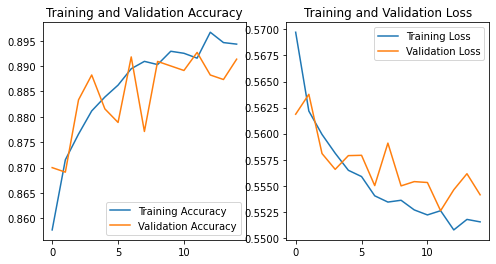

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [39]:
vg = datagen.flow_from_dataframe(
        dataframe=training_set, 
        subset='validation',
        classes=topics,
        color_mode='rgb',
        x_col='full_path', 
        y_col='labels', 
        class_mode='categorical', 
        target_size=target_size,
        shuffle=False
        )

/home/matvieir/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 24789 invalid image filename(s) in x_col="full_path". These filename(s) will be ignored.
  warnings.warn(


Found 2246 validated image filenames belonging to 2 classes.


In [40]:
val_predictions = model.predict(vg)
val_predictions

array([[1.0000000e+00, 4.8534768e-14],
       [1.0000000e+00, 7.2841333e-38],
       [1.0000000e+00, 4.1561452e-21],
       ...,
       [1.0000000e+00, 9.1753117e-19],
       [3.6410756e-07, 9.9995470e-01],
       [9.7161835e-01, 1.9634785e-05]], dtype=float32)

In [41]:
from collections import Counter

total = Counter()
correct = Counter()
for i in range(len(vg.classes)):
    true_y = vg.classes[i]
    for l in true_y:
        total[l]+=1
    predicted_y = np.argwhere(val_predictions[i]>=0.5)
    for p in predicted_y:
        if p[0] in true_y:
            correct[p[0]]+=1

for k in sorted(total.keys()):
    print(class_names[k].split(".")[-1], "{}/{} == {}".format(correct[k], total[k], correct[k]/total[k]))

Sports 946/1099 == 0.8607825295723385
Biology 971/1158 == 0.8385146804835925


In [42]:
name_id_map

{'Culture.Sports': 0, 'STEM.Biology': 1}

In [43]:
def get_y_true(classes, preset_nr_classes=0):
    """Gets one-hot encoded matrix of format (nr_images)x(nr_classes)."""
    nr_images = len(classes)
    if not preset_nr_classes:
        nr_classes = len(set([item for sublist in classes for item in sublist]))
    else:
        nr_classes = preset_nr_classes
    y_true = np.zeros((nr_images, nr_classes))
    for row_idx, row in enumerate(classes):
        for idx in row:
            y_true[row_idx, idx] = 1
    return y_true

/home/matvieir/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Average precision scores (macro):
0.8373137009889237

 ROC AUC score:
0.9456582111181828


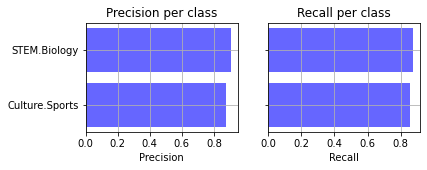

In [47]:
from sklearn.metrics import classification_report, average_precision_score, roc_auc_score

threshold = 0.2

y_pred = 1 * (val_predictions > threshold)

y_true = get_y_true(vg.classes)

n_classes = y_true.shape[1]
metrics_df = pd.DataFrame(classification_report(y_true, y_pred, target_names=list(vg.class_indices), output_dict=True)).transpose()
metrics_df['index'] = np.concatenate((np.arange(start=0, stop=n_classes), [None, None, None, None]))

# Output macro and micro accuracies
# with open(f'{self.results_path}/per_class_metrics', 'w') as f:
#     metrics_df.to_string(f)
# print(metrics_df.tail(4))

# Average precision score
# The average_precision_score function computes the average precision (AP) from prediction scores. The value is between 0 and 1 and higher is better. With random predictions, the AP is the fraction of positive samples.
print('\nAverage precision scores (macro):')
print(average_precision_score(y_true, y_pred, average='macro'))
# print(average_precision_score(y_true, y_pred, average='weighted'))

# ROC AUC score
print('\n ROC AUC score:')
print(roc_auc_score(y_true, val_predictions))

# Precision and recall for each class
fig, axs = plt.subplots(1, 2, figsize=(6,2))

# Precision
sorted_indices_precision = np.argsort(metrics_df.precision[0:n_classes])
sorted_precisions_per_class = metrics_df.precision[0:n_classes][sorted_indices_precision]
# Recall
sorted_indices_recall = np.argsort(metrics_df.recall[0:n_classes])
sorted_recalls_per_class = metrics_df.recall[0:n_classes][sorted_indices_recall]
# Plot!
axs[0].set_title('Precision per class')
axs[0].barh(range(y_true.shape[1]), sorted_precisions_per_class, color='blue', alpha=0.6)
axs[0].set_yticks(range(n_classes))
axs[0].set_yticklabels(np.array(list(vg.class_indices.keys()))[sorted_indices_precision])
axs[0].set_xlabel('Precision')
axs[0].grid(True)
axs[1].set_title('Recall per class')
axs[1].barh(range(y_true.shape[1]), sorted_recalls_per_class, color='blue', alpha=0.6)
axs[1].set_yticks(range(n_classes))
axs[1].set_yticklabels([])
axs[1].set_xlabel('Recall')
axs[1].grid(True)
plt.savefig(f'precision_recall.png')